# Phase 4

**Learning posterior via Normalising Flow for Beta-Binomial model**
**Ying & Danny**
**Date:** 2025-07-08


## Beta as Toy Example

### A Glimpse of our example

Now assume our posterior is hard to find (actually in this example, it is easy to find.)

We assume our prior is $Beta(\alpha,\beta)$, and assume that we are doing binomial example.

We conducted N independent experiments, each consisting of n Bernoulli trials with a common success probability $\theta$. In each experiment, we would oberserve the number of successes $y_{obs} \sim Binomial(n,\theta)$, for $i$= 1,...,N.

By conjugate pairs, we know that the true posterior would be $Beta(\alpha + \Sigma_y,\beta+Nn-\Sigma_y)$

**Now, for $\alpha = 2$ $\beta = 5$, $\Sigma_y$ = 15, N = 3, n = 11:**

**The plot of true posterior of Beta is given below:**

Check that the mean is simply $\frac{\alpha + \Sigma_y}{\alpha+\beta+Nn} = \frac{17}{40} \approx 0.425 $


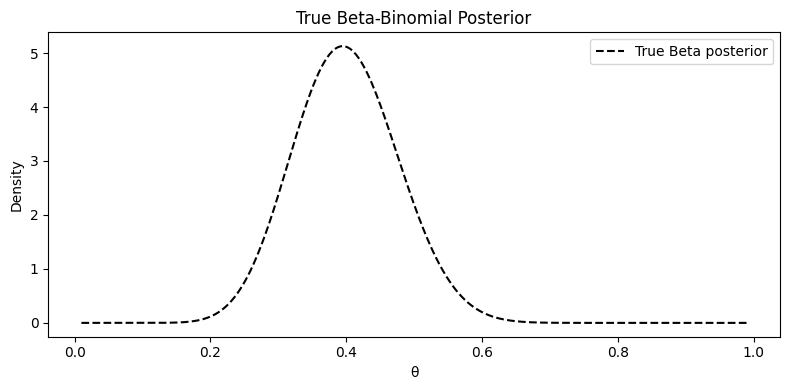

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist

def plot_true_posterior(x_grid, alpha_post, beta_post):
    true_pdf = beta_dist.pdf(x_grid, a=alpha_post, b=beta_post)

    plt.figure(figsize=(8, 4))
    plt.plot(x_grid, true_pdf, '--', label='True Beta posterior', color='black')
    plt.xlabel('θ')
    plt.ylabel('Density')
    plt.title('True Beta-Binomial Posterior')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Parameters and data
all_y_obs = torch.tensor([7., 3., 4., 6., 2., 8., 5., 1., 9., 10.])  # pool of observations
n_trials = 11
alpha0, beta0 = 2.0, 5.0
x = np.linspace(0.01, 0.99, 500)

# Use N = 3
N = 3
y_obs = all_y_obs[:N]
sum_y = y_obs.sum()
alpha_post = alpha0 + sum_y
beta_post = beta0 + N * n_trials - sum_y

#  true posterior
plot_true_posterior(x_grid=x, alpha_post=alpha_post.item(), beta_post=beta_post.item())



### Our target
We want to check whether NF has equivalently expressive power as the true posterior.
In this case , we assume a normalising flow from a standard normal distribution would well fit the posterior, who is simply an affine transformation and a sigmoid function.

### Evaluating method: KL-Divergence

We assume our our normalising flow gives us the transformed distribution $q(\theta|y)$
So We now use KL-divergence to represent the distance between the true posterior and our estimated posterior.

$$
\mathrm{KL}(q_\phi(\theta \mid \mathbf{y}) \,\|\, \pi(\theta \mid \mathbf{y})) 
= \mathbb{E}_{q_\phi(\theta \mid \mathbf{y})} 
\left[ \log \frac{q_\phi(\theta \mid \mathbf{y})}{\pi(\theta \mid \mathbf{y})} \right]
$$

And based on Beyesian theorem, we have:
$$
\pi(\theta \mid \mathbf{y}) \propto \pi(\mathbf{y} \mid \theta) \pi(\theta)
$$



Plugging into the KL expression:

\begin{align}
\mathrm{KL}(q_\phi \,\|\, \pi) 
&= \mathbb{E}_{q_\phi} \left[
\log q_\phi(\theta \mid \mathbf{y}) 
- \log \pi(\mathbf{y} \mid \theta) 
- \log \pi(\theta) 
+ \log \pi(\mathbf{y}) 
\right]
\end{align}

Since $\pi(\mathbf{y})$ is constant with respect to $\theta$, it can be dropped when optimizing:

\begin{equation}
\mathrm{KL}(q_\phi \,\|\, \pi) 
= \mathbb{E}_{q_\phi} \left[
\log q_\phi(\theta \mid \mathbf{y}) 
- \log \pi(\mathbf{y} \mid \theta) 
- \log \pi(\theta) 
\right] + \text{const}
\end{equation}

Thus, our variational objective (negative ELBO) is defined as:

\begin{equation}
\mathcal{L}(\phi) 
= \mathbb{E}_{q_\phi} \left[
\log q_\phi(\theta \mid \mathbf{y}) 
- \log \pi(\mathbf{y} \mid \theta) 
- \log \pi(\theta)
\right]
\end{equation}

Minimizing $\mathcal{L}(\phi)$ is equivalent to minimizing the KL divergence between the variational approximation and the true posterior.



### Training Principle

Since we've defined the loss function to be :

$$
\mathcal{L}(\phi) =  \log q\phi(\theta \mid \mathbf{y}) 
- \log \pi(\mathbf{y} \mid \theta) - \log \pi(\theta) 
$$
So we need to find the Log_prior, Log_likelihood and $p(\theta|y)$

1. Log_prior: It is obtained from the beta:
`log_prior = Beta(alpha0, beta0).log_prob(theta)`
2. Log likelihood logp(y∣θ), assuming Binomial trials:
`log_lik = Binomial(n_trials, theta_rep).log_prob(y_rep).sum(dim=1)`

3. Log flow density derived using the change-of-variable formula:
`log_q = log_qz - torch.log(scale) - torch.log(theta * (1 - theta))
`


Recall from the "Deep learning" book, our $q(\theta|y)$ is expressed as :

$$
Pr(q(\theta|y)) = \left| \frac{\partial \mathbf{f}[z, \boldsymbol{y}]}{\partial z} \right|^{-1} \cdot Pr(q(z)),

$$
By taking log of this equation , we obtain
$$
log(q(\theta|y)=log(q(z))-log|\frac{d\theta}{dz}|
$$
Using:
$$
\frac{d\theta}{dz} = \frac{d}{dz}\sigma(az+b) = a\times\theta\times(1-\theta)
$$

this is how our `log_q = log_qz - torch.log(scale) - torch.log(theta * (1 - theta))
` comes from.



### Start Training

We define the basic affine transformation as `shift` and `scale`, and the transformed theta would also experience a sigmoid function then our log_q and theta is put into the loss function.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist
import numpy as np
from tqdm import trange
torch.manual_seed(0)

In [11]:

# -------- Base class for Flow --------
class BaseFlow(nn.Module):
    def __init__(self):
        super().__init__()

    def sample(self, batch_size, y_obs):
        raise NotImplementedError

    def eval_log_prob(self, x_grid, y_obs):
        raise NotImplementedError

# -------- Affine Flow in Logit Space --------
class AffineFlowLogit(BaseFlow):
    def __init__(self, obs_dim):
        super().__init__()
        self.linear = nn.Linear(obs_dim, 2)

    def _get_params(self, y_obs):
        params = self.linear(y_obs.unsqueeze(0))  # (1, 2)
        log_scale = params[0, 0]
        shift = params[0, 1]
        scale = torch.exp(log_scale)
        return scale, shift

    def sample(self, batch_size, y_obs):
        z = torch.randn(batch_size)
        scale, shift = self._get_params(y_obs)
        logit_theta = scale * z + shift
        theta = torch.sigmoid(logit_theta).clamp(1e-6, 1 - 1e-6)

        log_qz = torch.distributions.Normal(0, 1).log_prob(z)
        log_jacobian = torch.log(theta * (1 - theta))
        log_q = log_qz - torch.log(scale) - log_jacobian
        return theta, log_q

    def eval_log_prob(self, x_grid, y_obs):
        scale, shift = self._get_params(y_obs)
        x_t = torch.tensor(x_grid)
        logit_x = torch.log(x_t / (1 - x_t))
        z_x = (logit_x - shift) / scale
        log_qz = torch.distributions.Normal(0, 1).log_prob(z_x)
        log_qx = log_qz - torch.log(scale) - torch.log(x_t * (1 - x_t))
        return log_qx.exp().detach().numpy()


In [12]:

# -------- Training Function --------
def train_flow(flow, y_obs, alpha0, beta0, n_trials, n_epochs=1000, n_samples=1000, lr=1e-3):
    optimizer = optim.Adam(flow.parameters(), lr=lr)
    N = y_obs.shape[0]
    losses = [] 
    for epoch in trange(n_epochs,desc="Training Flow"):
        optimizer.zero_grad()
        theta, log_q = flow.sample(n_samples, y_obs)
        # Prior: Beta(α0, β0)
        log_prior = torch.distributions.Beta(alpha0, beta0).log_prob(theta)
        # Likelihood: product of Binomial(n_trials, θ_i)
        theta_rep = theta.unsqueeze(1).expand(-1, N)
        y_rep = y_obs.unsqueeze(0).expand_as(theta_rep)
        log_lik = torch.distributions.Binomial(n_trials, theta_rep).log_prob(y_rep).sum(dim=1)
        # ELBO
        elbo = (log_prior + log_lik - log_q).mean()
        loss = -elbo
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    plt.figure(figsize=(6, 4))
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Negative ELBO")
    plt.title("Training Loss Curve")
    plt.tight_layout()
    plt.show()
    return losses




--- Training with N = 3 observations ---


Training Flow: 100%|██████████| 1000/1000 [00:01<00:00, 941.93it/s]


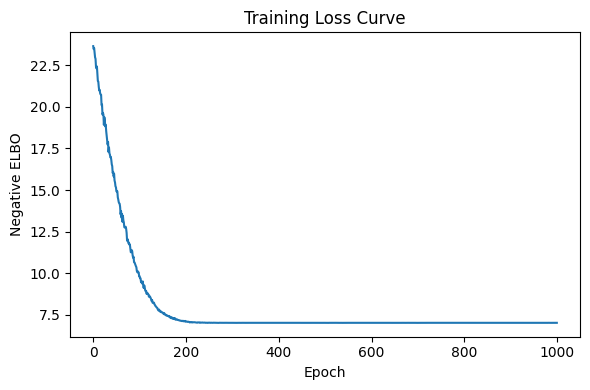

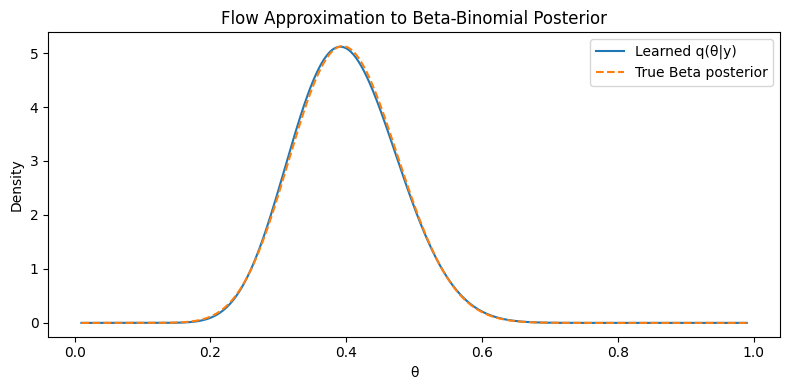

In [13]:

# -------- Plotting Function --------
def plot_density(flow, y_obs, x_grid, alpha_post, beta_post):
    q_pdf = flow.eval_log_prob(x_grid, y_obs)
    true_pdf = beta_dist.pdf(x_grid, a=alpha_post, b=beta_post)

    plt.figure(figsize=(8, 4))
    plt.plot(x_grid, q_pdf, '-', label='Learned q(θ|y)')
    plt.plot(x_grid, true_pdf, '--', label='True Beta posterior')
    plt.xlabel('θ')
    plt.ylabel('Density')
    plt.title('Flow Approximation to Beta-Binomial Posterior')
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------- Main Program --------
if __name__ == "__main__":
    
    all_y_obs = torch.tensor([7., 3., 4., 6., 2., 8., 5., 1., 9., 10.])  # pool of observations
    n_trials = 11
    alpha0, beta0 = 2.0, 5.0

    x = np.linspace(0.01, 0.99, 500)

    for N in [3]:
        print(f"\n--- Training with N = {N} observations ---")
        
        y_obs = all_y_obs[:N]  # select first N elements
        sum_y = y_obs.sum()
        alpha_post = alpha0 + sum_y
        beta_post = beta0 + N * n_trials - sum_y

        flow = AffineFlowLogit(obs_dim=N)
        train_flow(flow, y_obs, alpha0, beta0, n_trials)
        plot_density(flow, y_obs, x_grid=x, alpha_post=alpha_post.item(), beta_post=beta_post.item())


### Highlights

1. The results shows that we are fitting the true Beta posterior well.
2. We use n_trials = 10, and the number of experiments is 10, indeed , we will find that for N>=3, the fitting is good enough.
3. Here the result is not sensitive to the architecture of our NN, since the effect is quite similar for lr = 1e-2 or lr = 1e-3, and the epoch converges for epoch >200

## Gamma as Posterior Example
We now try the case for Gamma-Poisson Example 

Prior is Gamma($\alpha$,$\beta$) , and we obeserve $y_1,y_2...,y_n$ for each pair of theta
 - Prior : $\theta \sim Gamma(\alpha_0,\beta_0)$
 - Likelihood:
    $y_i\sim Poisson(\theta)$, i = 1,...,N

By conjugacy, the posterior will also be a Gamma distribution , and we are using a Normalising flow from standard normal distribution to this posterior

$$\theta \mid \mathbf{y} \sim \mathrm{Gamma} \left( \alpha_0 + \sum_{i} y_i,\, \beta_0 + N \right)
$$


### Define the Structure of FLow

The flow is defined as

$$\log \theta = a(\mathbf{y}) \cdot z + b(\mathbf{y})
$$

where

$$
\theta = \exp(az + b) \in (0, \infty)

$$

### Change of vairiables
Still, we use the standard transformation for the density

$$
Pr(q(\theta|y)) = \left| \frac{\partial \mathbf{f}[z, \boldsymbol{y}]}{\partial z} \right|^{-1} \cdot Pr(q(z)),

$$
By taking log of this equation , we obtain
$$
log(q(\theta|y)=log(q(z))-log|\frac{d\theta}{dz}|
$$
Using:
$$
\frac{d\theta}{dz} = \frac{d}{dz}\exp(az+b) = a\times\theta
$$
We can arrange the log_q to be :
$$
log(q(\theta|y)=log(q(z))-log|a|-log|\theta|
$$
which is the code `log_q = log_qz - torch.log(scale) - torch.log(theta)
`

### ELBO Objective
Our target is to minimize the value of KL, ie, minimising the loss:


$$\mathcal{L}(\phi) = \mathbb{E}_{q_\phi(\theta \mid \mathbf{y})} \left[ \log p(\theta) + \log p(\mathbf{y} \mid \theta) - \log q_\phi(\theta \mid \mathbf{y}) \right]
$$
- where we can compute $log(p(\theta))$ via Gamma;

- compute $logp(y|\theta)$ via Poisson

- compute $q(\theta|y)$ via change of variable

---

## The code is shown below

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import gamma as gamma_dist
import numpy as np
from tqdm import trange
torch.manual_seed(0)
# -------- Base class for Flow --------
class BaseFlow(nn.Module):
    def __init__(self):
        super().__init__()
    def sample(self, batch_size, y_obs):
        """
        Sample θ from q(θ|y_obs)
        Returns:
            theta: shape (batch_size,)
            log_q: shape (batch_size,)
        """
        raise NotImplementedError
    def eval_log_prob(self, x_grid, y_obs):
        """
        Evaluate the approximate posterior density q(θ|y_obs) on a grid
        """
        raise NotImplementedError

In [15]:

# -------- Affine Exp Flow --------
class AffineFlowExp(BaseFlow):
    def __init__(self, obs_dim):
        super().__init__()
        self.linear = nn.Linear(obs_dim, 2)

    def _get_params(self, y_obs):
        params = self.linear(y_obs.unsqueeze(0))  # shape (1, 2)
        log_scale = params[0, 0]
        shift     = params[0, 1]
        scale     = torch.exp(log_scale)
        return scale, shift

    def sample(self, batch_size, y_obs):
        z = torch.randn(batch_size)
        scale, shift = self._get_params(y_obs)
        log_theta = (scale * z + shift).clamp(min=-10, max=10)
        theta = torch.exp(log_theta).clamp(min=1e-6, max=1e2)

        # log q(θ|y_obs)
        log_qz = torch.distributions.Normal(0, 1).log_prob(z)
        log_jacobian = torch.log(theta)
        log_q = log_qz - torch.log(scale) - log_jacobian
        return theta, log_q

    def eval_log_prob(self, x_grid, y_obs):
        scale, shift = self._get_params(y_obs)
        x_t = torch.tensor(x_grid)
        log_x = torch.log(x_t)
        z_x = (log_x - shift) / scale
        log_qz = torch.distributions.Normal(0, 1).log_prob(z_x)
        log_qx = log_qz - torch.log(scale) - torch.log(x_t)
        return log_qx.exp().detach().numpy()





100%|██████████| 2000/2000 [00:00<00:00, 2428.87it/s]


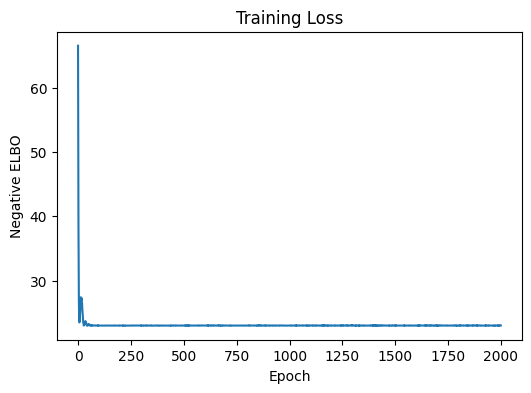

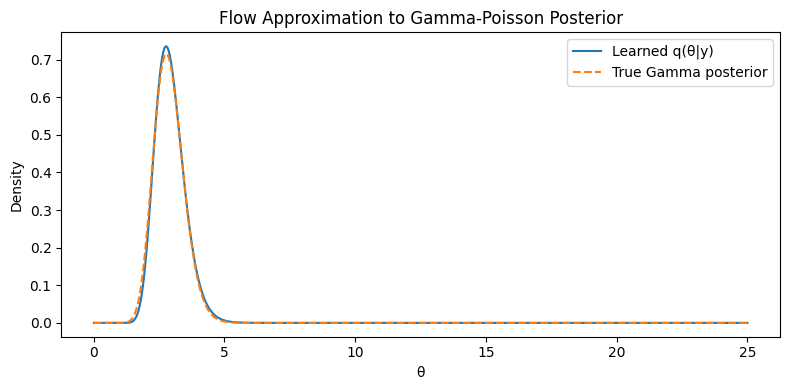

In [16]:

# -------- Training function --------
def train_flow(flow, y_obs, alpha0, beta0, n_epochs=2000, n_samples=200, lr=1e-2):
    optimizer = optim.Adam(flow.parameters(), lr=lr)
    N = y_obs.shape[0]
    losses = []
    for epoch in trange(n_epochs):
        optimizer.zero_grad()
        theta, log_q = flow.sample(n_samples, y_obs)

        # log p(θ)
        log_prior = torch.distributions.Gamma(alpha0, beta0).log_prob(theta)

        # log p(y | θ)
        theta_rep = theta.unsqueeze(1).expand(-1, N)
        y_rep = y_obs.unsqueeze(0).expand_as(theta_rep)
        log_lik = torch.distributions.Poisson(theta_rep).log_prob(y_rep).sum(dim=1)

        # ELBO
        elbo = (log_prior + log_lik - log_q).mean()
        loss = -elbo

        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    plt.figure(figsize = (6,4))
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Negative ELBO")
    plt.title("Training Loss")
    plt.show()

# -------- Plotting function --------
def plot_density(flow, y_obs, x_grid, alpha_post, beta_post):
    q_pdf = flow.eval_log_prob(x_grid, y_obs)
    true_pdf = gamma_dist.pdf(x_grid, a=alpha_post, scale=1 / beta_post)

    plt.figure(figsize=(8, 4))
    plt.plot(x_grid, q_pdf, '-', label='Learned q(θ|y)')
    plt.plot(x_grid, true_pdf, '--', label='True Gamma posterior')
    plt.xlabel('θ')
    plt.ylabel('Density')
    plt.title('Flow Approximation to Gamma-Poisson Posterior')
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------- Main Program --------
if __name__ == "__main__":
    # Observed data
    y_obs = torch.tensor([7., 4., 5., 8.])
    N = y_obs.shape[0]

    # Prior hyperparameters
    alpha0, beta0 = 2.0, 5.0

    # Posterior parameters for Gamma
    sum_y = y_obs.sum()
    alpha_post = alpha0 + sum_y
    beta_post  = beta0 + N

    # Grid for evaluation
    x = np.linspace(0.01, 25.0, 500)

    # Instantiate and train flow
    flow = AffineFlowExp(obs_dim=N)
    train_flow(flow, y_obs, alpha0, beta0)

    # Plot
    plot_density(flow, y_obs, x_grid=x, alpha_post=alpha_post, beta_post=beta_post)


## Highlight
- Here we only have 4 experiments, but the result is fitting very good 
- Our model converges after 200 epoches, so 2000 is far to many
- We require our learning rate to be at least smaller than 1e-2.
- The model is not sensitive to the number of samples, as long as the number of samples is larger than 200
---

## Bivariate Normal find Beta distribution

### Summary
Now we try the case for Beta Example based on standard bivariate normal distribution, because we want to estimate $\alpha$ and $\beta$ at the same time.

We try to use the normalising flow that takes $(z_1,z_2)$ as our input and our $\alpha$ and $\beta$ as output. The structure of our flow is defined below:

$$
z_{k+1} = A_k z_k + b_k
$$

where the k represents the layer of our flow, because multiple flows is more expressive than single flow. Here we contains some clamping technique so the flow is not invertible, hence we only consider the forward procedure and different number layers would differ in the effects.

### True Posterior
We observe data $y_1, y_2, \dots, y_n \sim \mathrm{Gamma}(\alpha, \beta)$, and our goal is to approximate the posterior distribution $$ p(\alpha, \beta \mid \mathbf{y}) $$ using variational inference.

The prior is set as:
$$
p(\alpha, \beta) = \text{Exp}(\lambda_\alpha) \cdot \text{Exp}(\lambda_\beta) = \lambda_\alpha e^{-\lambda_\alpha \alpha} \cdot \lambda_\beta e^{-\lambda_\beta \beta}
$$

The unnormalized posterior is:

$$
p(\alpha, \beta \mid \mathbf{y}) \propto
\left[ \prod_{i=1}^n \frac{\beta^\alpha}{\Gamma(\alpha)} y_i^{\alpha - 1} e^{-\beta y_i} \right] \cdot e^{-\lambda_\alpha \alpha - \lambda_\beta \beta}
$$

If we take a log on the posterior, we would obtain:

$$
\log p(\alpha, \beta \mid y) 
= n \alpha \log \beta 
- n \log \Gamma(\alpha) 
+ (\alpha - 1) \sum_{i=1}^{n} \log y_i 
- \beta \sum_{i=1}^{n} y_i 
- \lambda_\alpha \alpha 
- \lambda_\beta \beta
$$

This can be calculated in python, and we are able to plot them, as shown below:

---





In [17]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
import scipy.special as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sp


torch.manual_seed(123)
np.random.seed(123)

# %% 1. Data generation
true_alpha = 2.0    # Gamma shape parameter
true_beta  = 1.0    # Gamma rate parameter
num_obs    = 100    # Number of observations

# Generate observations y_i ~ Gamma(alpha, beta)
y_np = np.random.gamma(shape=true_alpha, scale=1.0 / true_beta, size=num_obs)
y_tensor = torch.tensor(y_np, dtype=torch.float32)

# Save the data
np.savetxt("y_train_gamma.txt", y_np)  # save the data
# print("trainning set is y_train_gamma.txt")


In [18]:
# Load the dataset
# Allow non-duplicate loading of the KMP (Intel MKL) library
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# Reading the training data from local
y_np = np.loadtxt("y_train_gamma.txt")
y_tensor = torch.tensor(y_np, dtype=torch.float32)
num_obs = len(y_tensor)
# Sufficient statistics (used as input to the flow)
sum_log_y = torch.sum(torch.log(y_tensor)).item()
sum_y     = torch.sum(y_tensor).item()
mean_log_y = sum_log_y / num_obs
mean_y     = sum_y / num_obs
summary_stats = torch.tensor([mean_log_y, mean_y], dtype=torch.float32)

# Prior hyperparameters: Exponential(λ)
lambda_alpha = 1.0
lambda_beta  = 1.0



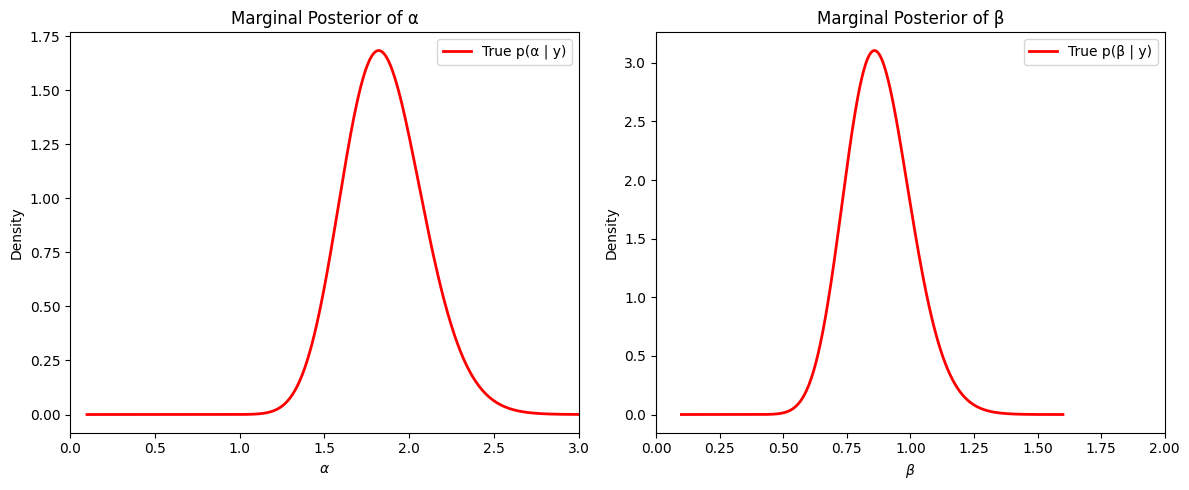

In [19]:
# Grids over alpha and beta
alpha_grid = np.linspace(0.1, 3.0, 600)     # horizontal axis (shape)
beta_grid  = np.linspace(0.1, 1.6, 600)     # vertical axis (rate)
AlphaGrid, BetaGrid = np.meshgrid(alpha_grid, beta_grid)

# Compute the unnormalized log posterior: log p(alpha, beta | y)
log_posterior_density = (
    num_obs * AlphaGrid * np.log(BetaGrid)
    - num_obs * sp.gammaln(AlphaGrid)
    + (AlphaGrid - 1) * sum_log_y
    - BetaGrid * sum_y
    - lambda_alpha * AlphaGrid
    - lambda_beta  * BetaGrid
)

# Step 1: Normalize the posterior (numerical stability)
log_posterior_density -= np.max(log_posterior_density)
posterior_density_true = np.exp(log_posterior_density)

d_alpha = alpha_grid[1] - alpha_grid[0]
d_beta  = beta_grid[1] - beta_grid[0]
posterior_density_true /= np.sum(posterior_density_true) * d_alpha * d_beta

# Step 2: Compute marginal densities
posterior_alpha_true = np.sum(posterior_density_true, axis=0) * d_beta  # p(alpha)
posterior_beta_true  = np.sum(posterior_density_true, axis=1) * d_alpha  # p(beta)

# Step 3: Plot estimated vs. true marginals
plt.figure(figsize=(12, 5))

# α marginal
plt.subplot(1, 2, 1)

plt.plot(alpha_grid, posterior_alpha_true, 'r-', linewidth=2, label='True p(α | y)')
plt.xlabel(r'$\alpha$')
plt.ylabel('Density')
plt.title('Marginal Posterior of α')
plt.xlim(0, 3)
plt.legend()

# β marginal
plt.subplot(1, 2, 2)

plt.plot(beta_grid, posterior_beta_true, 'r-', linewidth=2, label='True p(β | y)')
plt.xlabel(r'$\beta$')
plt.ylabel('Density')
plt.title('Marginal Posterior of β')
plt.xlim(0, 2)
plt.legend()

plt.tight_layout()
plt.show()


**Python code:**

```python
log_posterior_density = (
    num_obs * AlphaGrid * np.log(BetaGrid)
    - num_obs * sp.gammaln(AlphaGrid)
    + (AlphaGrid - 1) * sum_log_y
    - BetaGrid * sum_y
    - lambda_alpha * AlphaGrid
    - lambda_beta  * BetaGrid
)

### Interpretation of the figure
These two figures give us the marginal posterior of $\alpha$ and $\beta$, and now we are using normalising flow to estimate the posterior.

### Our Flow
The input is a tensor of shape `(batch_size, 2)`, sampled from the base distribution (typically `z ~ N(0, I)`).
`summary` is laceholder argument (currently unused, but reserved for future conditional flows if needed).

---

This flow model applies `K` affine transformations to the input `z`, where each affine transformation is defined by a symmetric 2×2 matrix:

$$
A = \begin{bmatrix}
a_{11} & a_{12} \\
a_{12} & a_{22}
\end{bmatrix}, \quad b \in \mathbb{R}^2
$$

The update rule is:

$$
z_{k+1} = A_k z_k + b_k
$$

At each step, the log-determinant of the Jacobian (`log|det A_k|`) is accumulated to compute the total volume change introduced by the flow.



In [20]:
class StructuredComposedLinearFlow2D(nn.Module):
    """
    Composition of K structured linear affine flows:
    Each A_k is a 2x2 matrix with symmetry A[0,1] == A[1,0]
    A = [[a11, a12],
         [a12, a22]]
    """
    def __init__(self, num_flows=3):
        super().__init__()
        self.num_flows = num_flows 
        self.a11s = nn.ParameterList() # The a11 in every flow
        self.a12s = nn.ParameterList() # The a12 in every flow
        self.a22s = nn.ParameterList() # The a22 in every flow
        self.bs   = nn.ParameterList() # The b in every flow

        for _ in range(num_flows):
            self.a11s.append(nn.Parameter(torch.tensor(1.0 + 0.01 * torch.randn(()))))
            self.a12s.append(nn.Parameter(torch.tensor(0.01 * torch.randn(()))))
            self.a22s.append(nn.Parameter(torch.tensor(1.0 + 0.01 * torch.randn(()))))
            self.bs.append(nn.Parameter(torch.zeros(2)))

    def forward(self, summary, z):
        z_k = z # Our initial z (from the base)
        log_det_total = 0.0 # Used later of change of variable

        for a11, a12, a22, b in zip(self.a11s, self.a12s, self.a22s, self.bs): # we have sef.a11s, means we browse every a11 in a11s list
            A = torch.stack([
                torch.stack([a11, a12]),
                torch.stack([a12, a22])
            ])
            z_k = z_k @ A.t() + b
            _, log_det_A = torch.slogdet(A)
            log_det_total += log_det_A

        alpha_q = torch.exp(z_k[:, 0])
        beta_q  = torch.exp(z_k[:, 1])

        log_p0 = Normal(0, 1).log_prob(z).sum(dim=1)
        log_det_exp = z_k.sum(dim=1)
        log_q = log_p0 - log_det_total - log_det_exp

        return alpha_q, beta_q, log_q

### Training Process
Still, our target is to maximize the ELBO, and our loss is -ELBO:

$$
\mathcal{L}(\phi) = \mathbb{E}_{q_\phi(\alpha, \beta \mid \mathbf{y})} \left[ \log p(\alpha, \beta) + \log p(\mathbf{y} \mid \alpha, \beta) - \log q_\phi(\alpha, \beta \mid \mathbf{y}) \right]
$$

where
- Prior: 
$$
\log p(\alpha, \beta) = -\lambda_\alpha \alpha - \lambda_\beta \beta + \text{const}
$$

- Log-Likelihood : $$\log p(\alpha, \beta \mid y) = n \alpha \log \beta - n \log \Gamma(\alpha) + (\alpha - 1) \sum_{i=1}^{n} \log y_i - \beta \sum_{i=1}^{n} y_i - \lambda_\alpha \alpha - \lambda_\beta \beta$$
- Log_q:
$$\log q(\alpha, \beta) = \log p_0(\mathbf{z}) - \log |\det A| - \log \alpha - \log \beta
$$
---
We set the number of flows to be 1 , with learning rate of 1e-3, we choose epoches of 4000, and sampling 2000.

/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_75154/2570464328.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.a11s.append(nn.Parameter(torch.tensor(1.0 + 0.01 * torch.randn(()))))
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_75154/2570464328.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.a12s.append(nn.Parameter(torch.tensor(0.01 * torch.randn(()))))
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_75154/2570464328.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.a22s.app

Epoch 500 | Loss = 196.9026
Epoch 1000 | Loss = 179.0935
Epoch 1500 | Loss = 175.6346
Epoch 2000 | Loss = 172.9167
Epoch 2500 | Loss = 171.3498
Epoch 3000 | Loss = 170.3006
Epoch 3500 | Loss = 169.9806
Epoch 4000 | Loss = 169.9396


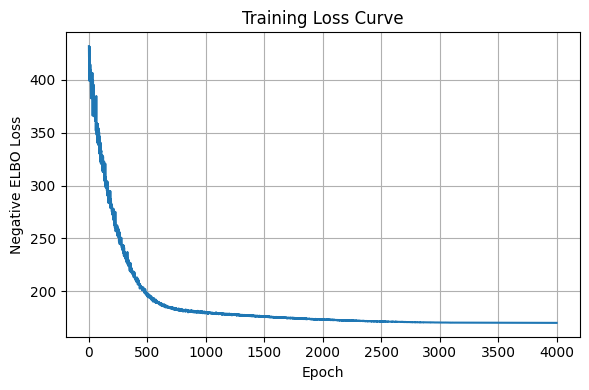

In [21]:
flow_model = StructuredComposedLinearFlow2D(num_flows=1) # We have chosen our flow to be 1

optimizer = optim.Adam(flow_model.parameters(), lr=1e-3)
base_dist = Normal(torch.zeros(2), torch.ones(2))

# %% 4. ELBO training
num_epochs = 4000
MC_samples = 2000

losses = []
for epoch in range(1, num_epochs + 1):
    z_sample = base_dist.sample((MC_samples,))
    alpha_q, beta_q, log_q = flow_model(summary_stats, z_sample)

    log_prior = -lambda_alpha * alpha_q - lambda_beta * beta_q
    log_likelihood = (
        num_obs * alpha_q * torch.log(beta_q.clamp(min=1e-8))
        - num_obs * torch.lgamma(alpha_q)
        + (alpha_q - 1) * sum_log_y
        - beta_q * sum_y
    )

    elbo = torch.mean(log_prior + log_likelihood - log_q)
    loss = -elbo

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch:3d} | Loss = {loss.item():.4f}")
    losses.append(loss.item())
    
plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Negative ELBO Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.tight_layout()
plt.show()


### Insight of number of flows
---
Since there is non-linear structure in the code `beta_q.clamp(min=1e-8)`, so when we increase the number of flows, we also increase the its power of expressive.

However, the effect is not huge, so a single flow is quite enough for such training.

As for the learning rate

By Multiplying them and adding together, we try to find what is the equivalent A and b
Actually , they are not equal , becasue we clamp for some variables in the code , for example beta_q, so it contains some non-linear structure , so by applying multiple layers of normalising flow, the results are not equivalent.

Now we are using the model of flow 1

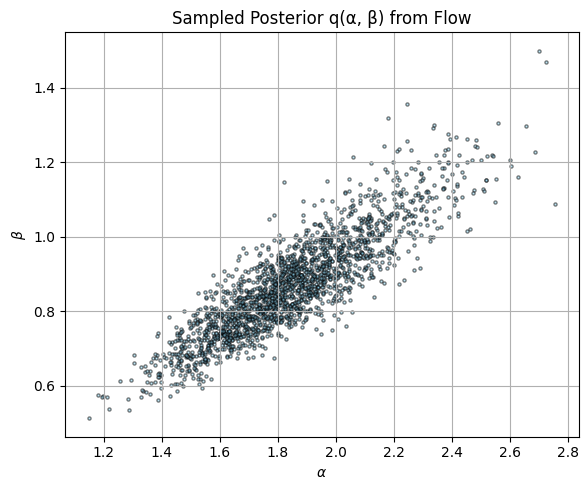

In [22]:
import torch
import matplotlib.pyplot as plt
from torch.distributions import Normal

# Step 1: Sample from base distribution
base_dist = Normal(torch.zeros(2), torch.ones(2))
z_sample = base_dist.sample((2000,))  # Sample 3000 points

# Step 2: Pass through the trained flow model

dummy_summary = None
alpha_q, beta_q, log_q = flow_model(dummy_summary, z_sample)

# Step 3: Detach and convert to NumPy for plotting
alpha_np = alpha_q.detach().cpu().numpy()
beta_np  = beta_q.detach().cpu().numpy()

# Step 4: Plot scatter plot ("cloud")
plt.figure(figsize=(6, 5))
plt.scatter(alpha_np, beta_np, s=5, alpha=0.5, c='skyblue', edgecolor='k')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title('Sampled Posterior q(α, β) from Flow')
plt.grid(True)
plt.tight_layout()
plt.show()


### Ploting the estimated posterior

By extracting the parameters of our trained model, we sample 2000 points from our bivariate normal distribution, and putting through the flow to obtain our $\alpha$ and $\beta$.

By plotting the histgrams of our samples and draw the true posterior, we can find they fit properly.

In [31]:
# Indeed ,since it is linear tranformation, we can still calculate the inverse by hand , we extract 
# A and b ， so in theory we can do the inverse, now we define the inverse procedure.

def evaluate_q(alpha_beta):  # input shape: [N, 2]
    z = alpha_beta
    for A, b in reversed(flow_layers):
        z = (z - b) @ torch.inverse(A).T
    log_p0 = Normal(0, 1).log_prob(z).sum(dim=1)  # log p(z)
    log_det = sum([torch.slogdet(A)[1] for A in flow_layers])  # constant
    log_q = log_p0 - log_det - alpha_beta.sum(dim=1)  # subtract Jacobian + exp
    return torch.exp(log_q)


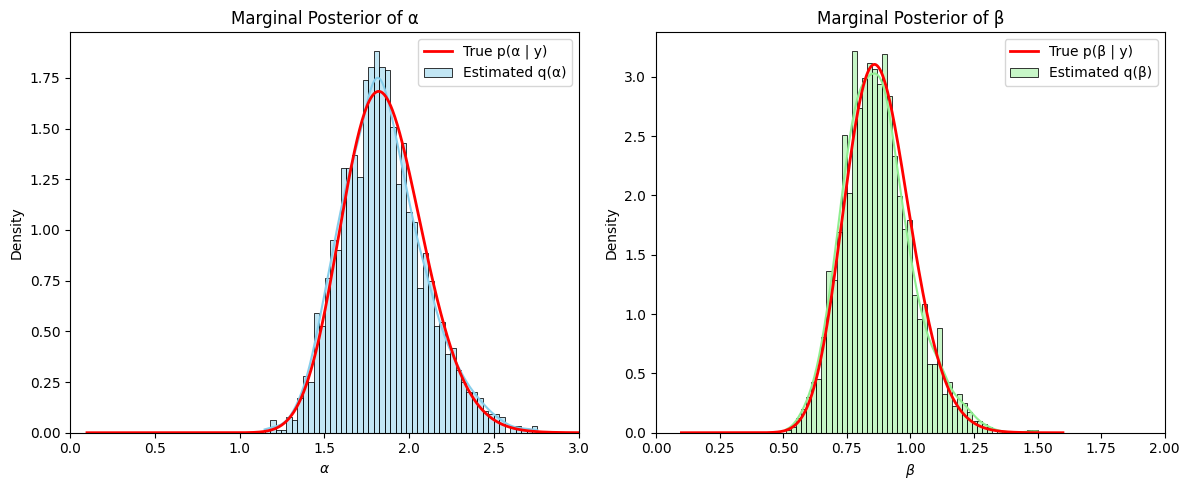

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sp

# Grids over alpha and beta
alpha_grid = np.linspace(0.1, 3.0, 600)     # horizontal axis (shape)
beta_grid  = np.linspace(0.1, 1.6, 600)     # vertical axis (rate)
AlphaGrid, BetaGrid = np.meshgrid(alpha_grid, beta_grid)

# Compute the unnormalized log posterior: log p(alpha, beta | y)
log_posterior_density = (
    num_obs * AlphaGrid * np.log(BetaGrid)
    - num_obs * sp.gammaln(AlphaGrid)
    + (AlphaGrid - 1) * sum_log_y
    - BetaGrid * sum_y
    - lambda_alpha * AlphaGrid
    - lambda_beta  * BetaGrid
)

# Step 1: Normalize the posterior (numerical stability)
log_posterior_density -= np.max(log_posterior_density)
posterior_density_true = np.exp(log_posterior_density)

d_alpha = alpha_grid[1] - alpha_grid[0]
d_beta  = beta_grid[1] - beta_grid[0]
posterior_density_true /= np.sum(posterior_density_true) * d_alpha * d_beta

# Step 2: Compute marginal densities
posterior_alpha_true = np.sum(posterior_density_true, axis=0) * d_beta  # p(alpha)
posterior_beta_true  = np.sum(posterior_density_true, axis=1) * d_alpha  # p(beta)

# Step 3: Plot estimated vs. true marginals
plt.figure(figsize=(12, 5))

# α marginal
plt.subplot(1, 2, 1)
sns.histplot(alpha_np, bins=50, stat='density', kde=True, color='skyblue', label='Estimated q(α)')
plt.plot(alpha_grid, posterior_alpha_true, 'r-', linewidth=2, label='True p(α | y)')
plt.xlabel(r'$\alpha$')
plt.ylabel('Density')
plt.title('Marginal Posterior of α')
plt.xlim(0, 3)
plt.legend()

# β marginal
plt.subplot(1, 2, 2)
sns.histplot(beta_np, bins=50, stat='density', kde=True, color='lightgreen', label='Estimated q(β)')
plt.plot(beta_grid, posterior_beta_true, 'r-', linewidth=2, label='True p(β | y)')
plt.xlabel(r'$\beta$')
plt.ylabel('Density')
plt.title('Marginal Posterior of β')
plt.xlim(0, 2)
plt.legend()

plt.tight_layout()
plt.show()


### Highlight
1. The fitting is doing good
2. The result is not sensitive to the number of flows, since only one flow is fitting very good.
3. The epoch converges after 4000
4. The learning rate is 1e-2, is similar for lr < 1e-2
